# <center> Feature engineering

# Imports

In [1]:
import time
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
import altair as alt
import missingno as msno
import unidecode

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import ensemble
from sklearn import impute
from sklearn import compose
from sklearn import metrics
from sklearn import inspection

import lightgbm as lgb

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

pd.set_option('display.max_rows',    1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width',       1000)

---
# <center> PART 1: PROCESS THE DATA
---

# Read data

In [2]:
train = pd.read_csv("data/train.csv", index_col="Id")
test  = pd.read_csv("data/test.csv",  index_col="Id")
sub   = pd.read_csv("data/sampleSubmission.csv", index_col="Id")
print(len(train), len(test), len(sub))
train.head()

160435 68758 68758


,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio
Id,,,,,,,,,,,,,
0,OPEL,VECTRA,33 días,la_rioja,Arnedo,2005.0,200000.0,manual,120.0,diesel,5.0,Profesional,2200
1,NISSAN,PRIMERA,43 horas,aragon,Teruel,2008.0,400000.0,manual,100.0,diesel,4.0,Particular,3500
2,RENAULT,CLIO BUSINESS DCI 75 ECO2,14 horas,sevilla,Camas,2014.0,53565.0,manual,75.0,diesel,5.0,Profesional,8200
3,MERCEDES-BENZ,CLASE CLS,1 hora,burgos,Burgos,2007.0,215000.0,automat,224.0,diesel,4.0,Particular,12500
4,RENAULT,CAPTUR LIFE ENERGY DCI 90 ECO2 EURO 6,45 días,caceres,Caceres,2016.0,119945.0,manual,90.0,diesel,5.0,Profesional,9900


# Data fixing

In [3]:
def cleanString(valor):
    return unidecode.unidecode(valor.upper().strip())

def clean(data):
    
    data['Marca']  = data['Marca'].apply(cleanString)
    data['Modelo'] = data['Modelo'].apply(cleanString)

    data['Marca'].replace("MERCEDES", "MERCEDES-BENZ",     inplace=True) # Fix Mercedes
    data['Modelo'].replace("CLASE ", "CLASE_", regex=True, inplace=True) # Fix Mercedes models
    data['Modelo'].replace("SERIE ", "SERIE_", regex=True, inplace=True) # Fix BMW models
    data['Modelo'].replace("RANGE ROVER ", "", regex=True, inplace=True) # Fix Land Rover models
    
    return data

train = clean(train)
test  = clean(test)

# Feature engeniring: Provincias lat & lon

In [4]:
provincias = train['Provincia'].unique().tolist()

In [5]:
def getLatLon():
    provincias_loc = pd.DataFrame(columns=('Provincia', 'Latitude', 'Longitude'))

    for p in provincias:
        loc = geolocator.geocode(p.replace('_', ' ') + ", España")
        print(p,"-->", loc)
        provincias_loc = provincias_loc.append({'Provincia':p , 'Latitude':loc.latitude, 'Longitude':loc.longitude}, ignore_index=True)
        time.sleep(.5)

    provincias_loc.to_csv("data/provincias.csv", index=False)

#getLatLon()
provincias_loc = pd.read_csv("data/provincias.csv")
provincias_loc.head()

,Provincia,Latitude,Longitude
0,la_rioja,42.328553,-2.467492
1,aragon,41.378729,-0.763937
2,sevilla,37.388630,-5.995340
3,burgos,42.343926,-3.696977
4,caceres,39.474517,-6.371676


In [6]:
alt.Chart(provincias_loc).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    #color='leading digit:N',
    tooltip='Provincia:N'
)

alt.Chart(...)

In [7]:
train = pd.merge(train, provincias_loc, on='Provincia', how='left')
test  = pd.merge(test,  provincias_loc, on='Provincia', how='left')

In [8]:
train.head(3)

,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio,Latitude,Longitude
0,OPEL,VECTRA,33 días,la_rioja,Arnedo,2005.0,200000.0,manual,120.0,diesel,5.0,Profesional,2200,42.328553,-2.467492
1,NISSAN,PRIMERA,43 horas,aragon,Teruel,2008.0,400000.0,manual,100.0,diesel,4.0,Particular,3500,41.378729,-0.763937
2,RENAULT,CLIO BUSINESS DCI 75 ECO2,14 horas,sevilla,Camas,2014.0,53565.0,manual,75.0,diesel,5.0,Profesional,8200,37.388630,-5.995340


# Feature engeniring: Modelo padre

In [4]:
def getMotorLitros(modelo):
    if ". " in modelo:
        idx   = modelo.index(". ")
        left  = modelo[idx-1:idx]
        right = modelo[idx+2:idx+3]
        if left.isnumeric() and right.isnumeric():
            return left+"."+right
        else:
            return None        
    else:
        return None

train['Motor_litros'] = train['Modelo'].apply(getMotorLitros)
test['Motor_litros']  = test['Modelo'].apply(getMotorLitros)

In [5]:
train["Modelo_1st"] = train.Modelo.str.split().str.get(0)
test["Modelo_1st"]  = test.Modelo.str.split().str.get(0)

In [6]:
modelosPadre = []

def estaEnLosModelosPadre(nuevoModelo):
    for modeloPadre in modelosPadre:
        if modeloPadre in nuevoModelo:
            return True
    return False

modelos = pd.concat([train.Modelo, test.Modelo]).value_counts().index.tolist()
for m in modelos:
    if not estaEnLosModelosPadre(m):
        modelosPadre.append(m)


len(modelos), len(modelosPadre)

(59684, 590)

In [7]:
def modeloPadre(Modelo):
    for modeloPadre in modelosPadre:
        if modeloPadre in Modelo:
            return modeloPadre
        
train["Modelo_padre"] = train["Modelo"].apply(modeloPadre)
test["Modelo_padre"]  = test["Modelo"].apply(modeloPadre)

In [9]:
train[["Marca", "Modelo_padre", "Modelo_1st", "Motor_litros", "Modelo"]].sample(10)

,Marca,Modelo_padre,Modelo_1st,Motor_litros,Modelo
Id,,,,,
56059,MERCEDES-BENZ,CLASE_C,CLASE_C,None,CLASE_C C 200 CDI CLASSIC FAMILIAR
16679,OPEL,ASTRA,ASTRA,1.4,ASTRA 1. 4 TURBO 92KW 125CV DYNAMIC
152529,MERCEDES-BENZ,CLASE_C,CLASE_C,None,CLASE_C C COUPE 220 D 4MATIC
55432,PORSCHE,COUPE,911,None,911 CARRERA S COUPE 355CV 997
29934,RENAULT,CAPTUR,CAPTUR,None,CAPTUR ZEN ENERGY TCE 87KW 120CV EDC
144346,AUDI,A4,A4,None,A4 AVANT S LINE 35 TDI 110KW S TRONIC
152300,FIAT,500,500X,1.3,500X POP STAR 1. 3 MJET 70KW 95CV 4X2
77393,HYUNDAI,ATOS,ATOS,1.0,ATOS 1. 0I GLS
66431,BMW,SERIE_5,SERIE_5,None,SERIE_5


# Feature engeniring: Tiempo -> Pasar todo a días:
Tipos de Tiempo
- 688 días
- 2 horas
- 33 min
- 54 seg
- nuevo anuncio
- destacado

In [14]:
# Do some checking
filter_dias  = train["Tiempo"].str.endswith('días')
filter_hora  = train["Tiempo"].str.endswith('hora')
filter_horas = train["Tiempo"].str.endswith('horas')
filter_min   = train["Tiempo"].str.endswith('min')
filter_seg   = train["Tiempo"].str.endswith('seg')
filter_nuevo = train["Tiempo"].str.endswith('nuevo anuncio')
filter_dest  = train["Tiempo"].str.endswith('destacado')

len(train) == len(train[filter_dias])  + \
len(train[filter_hora])  + len(train[filter_horas]) + \
len(train[filter_min])   + len(train[filter_seg])  + \
len(train[filter_nuevo]) + len(train[filter_dest])

True

In [15]:
def tranform2type(Tiempo):
    if   Tiempo.endswith('días'):  return 'dias'
    elif Tiempo.endswith('horas'): return 'horas'
    elif Tiempo.endswith('hora'):  return 'hora'
    elif Tiempo.endswith('min'):   return 'min'
    elif Tiempo.endswith('seg'):   return 'seg'
    elif Tiempo.endswith('nuevo anuncio'):  return 'nuevo anuncio'
    elif Tiempo.endswith('destacado'):      return 'destacado'

    
def tranform2dias(Tiempo):
    if   Tiempo.endswith('días'):  return int(Tiempo.replace(' días', ''))
    elif Tiempo.endswith('horas'): return int(Tiempo.replace(' horas', ''))/24
    elif Tiempo.endswith('hora'):  return int(Tiempo.replace(' hora', ''))/24
    elif Tiempo.endswith('min'):   return int(Tiempo.replace(' min', ''))/(60*24)
    elif Tiempo.endswith('seg'):   return int(Tiempo.replace(' seg', ''))/(60*60*24)
    elif Tiempo.endswith('nuevo anuncio'):  return 0
    elif Tiempo.endswith('destacado'):      return -1

train["Tiempo_días"] = train["Tiempo"].apply(tranform2dias) # Variable numerica
train["Tiempo_tipo"] = train["Tiempo"].apply(tranform2type) # Variable categorica

test["Tiempo_días"] = test["Tiempo"].apply(tranform2dias) # Variable numerica
test["Tiempo_tipo"] = test["Tiempo"].apply(tranform2type) # Variable categorica

In [16]:
train[["Tiempo", "Tiempo_días", "Tiempo_tipo"]].head()

,Tiempo,Tiempo_días,Tiempo_tipo
0,33 días,33.000000,dias
1,43 horas,1.791667,horas
2,14 horas,0.583333,horas
3,1 hora,0.041667,hora
4,45 días,45.000000,dias


In [17]:
train.sample(3)

,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio,Latitude,Longitude,Motor_litros,Modelo_1st,Modelo_padre,Tiempo_días,Tiempo_tipo
85358,OPEL,CORSA-E,24 horas,cadiz,Puerto Real,2002.0,65000.0,manual,59.0,gasolina,5.0,Profesional,1550,36.529829,-6.292568,None,CORSA-E,CORSA,1.0,horas
144478,MERCEDES-BENZ,E 350 BLUEFICENCI,3 días,leon,Ponferrada,2011.0,120000.0,automat,236.0,diesel,4.0,Profesional,18999,42.634145,-5.971415,None,E,3,3.0,dias
46030,KIA,CARNIVAL 2. 9 CRDI 6 PLAZAS,9 días,leon,Benavente,2004.0,259000.0,manual,143.0,diesel,5.0,Profesional,1800,42.634145,-5.971415,2.9,CARNIVAL,CARNIVAL,9.0,dias


# Rename to ascii colum names

In [18]:
train.rename(columns={'Año':         'Ano'},         inplace=True)
train.rename(columns={'Año_missing': 'Ano_missing'}, inplace=True)
train.rename(columns={'Tiempo_días': 'Tiempo_dias'}, inplace=True)

test.rename(columns={'Año':         'Ano'},         inplace=True)
test.rename(columns={'Año_missing': 'Ano_missing'}, inplace=True)
test.rename(columns={'Tiempo_días': 'Tiempo_dias'}, inplace=True)

# Save data

In [19]:
train.to_csv("data/train_featEng.csv", index_label="Id")

In [20]:
test.to_csv("data/test_featEng.csv", index_label="Id")

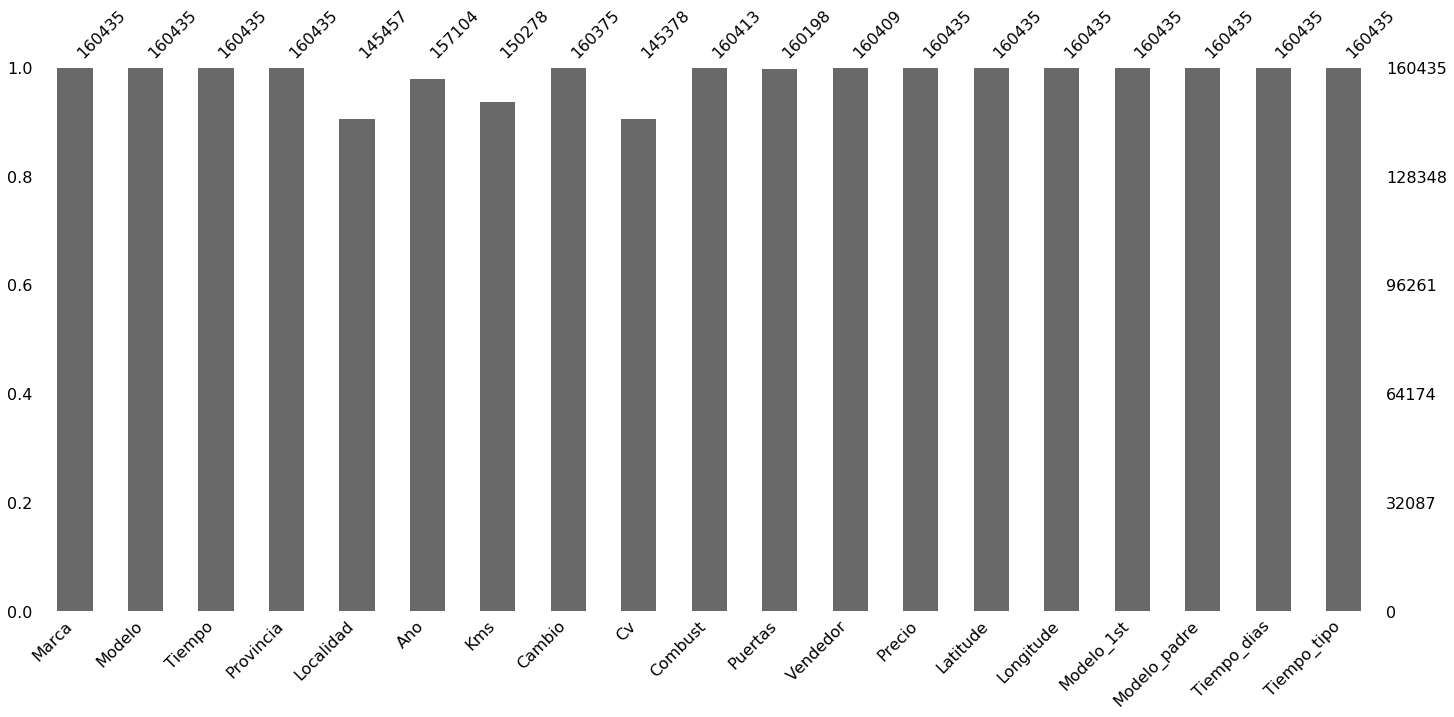

In [20]:
msno.bar(train)